In [1]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
import time
from multiprocessing import Process
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

## Calculate distortion coefficients and camera matrix

In [2]:
def get_imgpoints(camer_cal):
    """helper function to get imgpoints and objpoints."""
    imgpoints, objpoints = [], []
    for ind, fn in enumerate(os.listdir(camer_cal)):
        fn = os.path.join(camer_cal, fn)
        img = cv2.imread(fn)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # loop to find max possible points
        for i in range(9, 5, -1):
            for j in range(6, 3, -1):
                ret = False
                try:
                    ret, corners = cv2.findChessboardCorners(gray, (i, j), None)
                except:
                    continue
                if ret:
                    nx, ny = i, j
                    break
            if ret:
                break
        if ret:
            imgpoints.append(corners)
            objpoints.append(np.array([[[i, j, 0] for i in range(nx)] 
                                       for j in range(ny)]).astype(np.float32).reshape(-1, 3))
    return imgpoints, objpoints


camer_cal = './camera_cal'
start_time = time.time()
imgpoints, objpoints = get_imgpoints(camer_cal)
_, mtx, dist, __, ___ = cv2.calibrateCamera(objpoints, imgpoints, (1280, 720), None, None)
print('Time cost:%.2f'%(time.time() - start_time))

Time cost:6.78


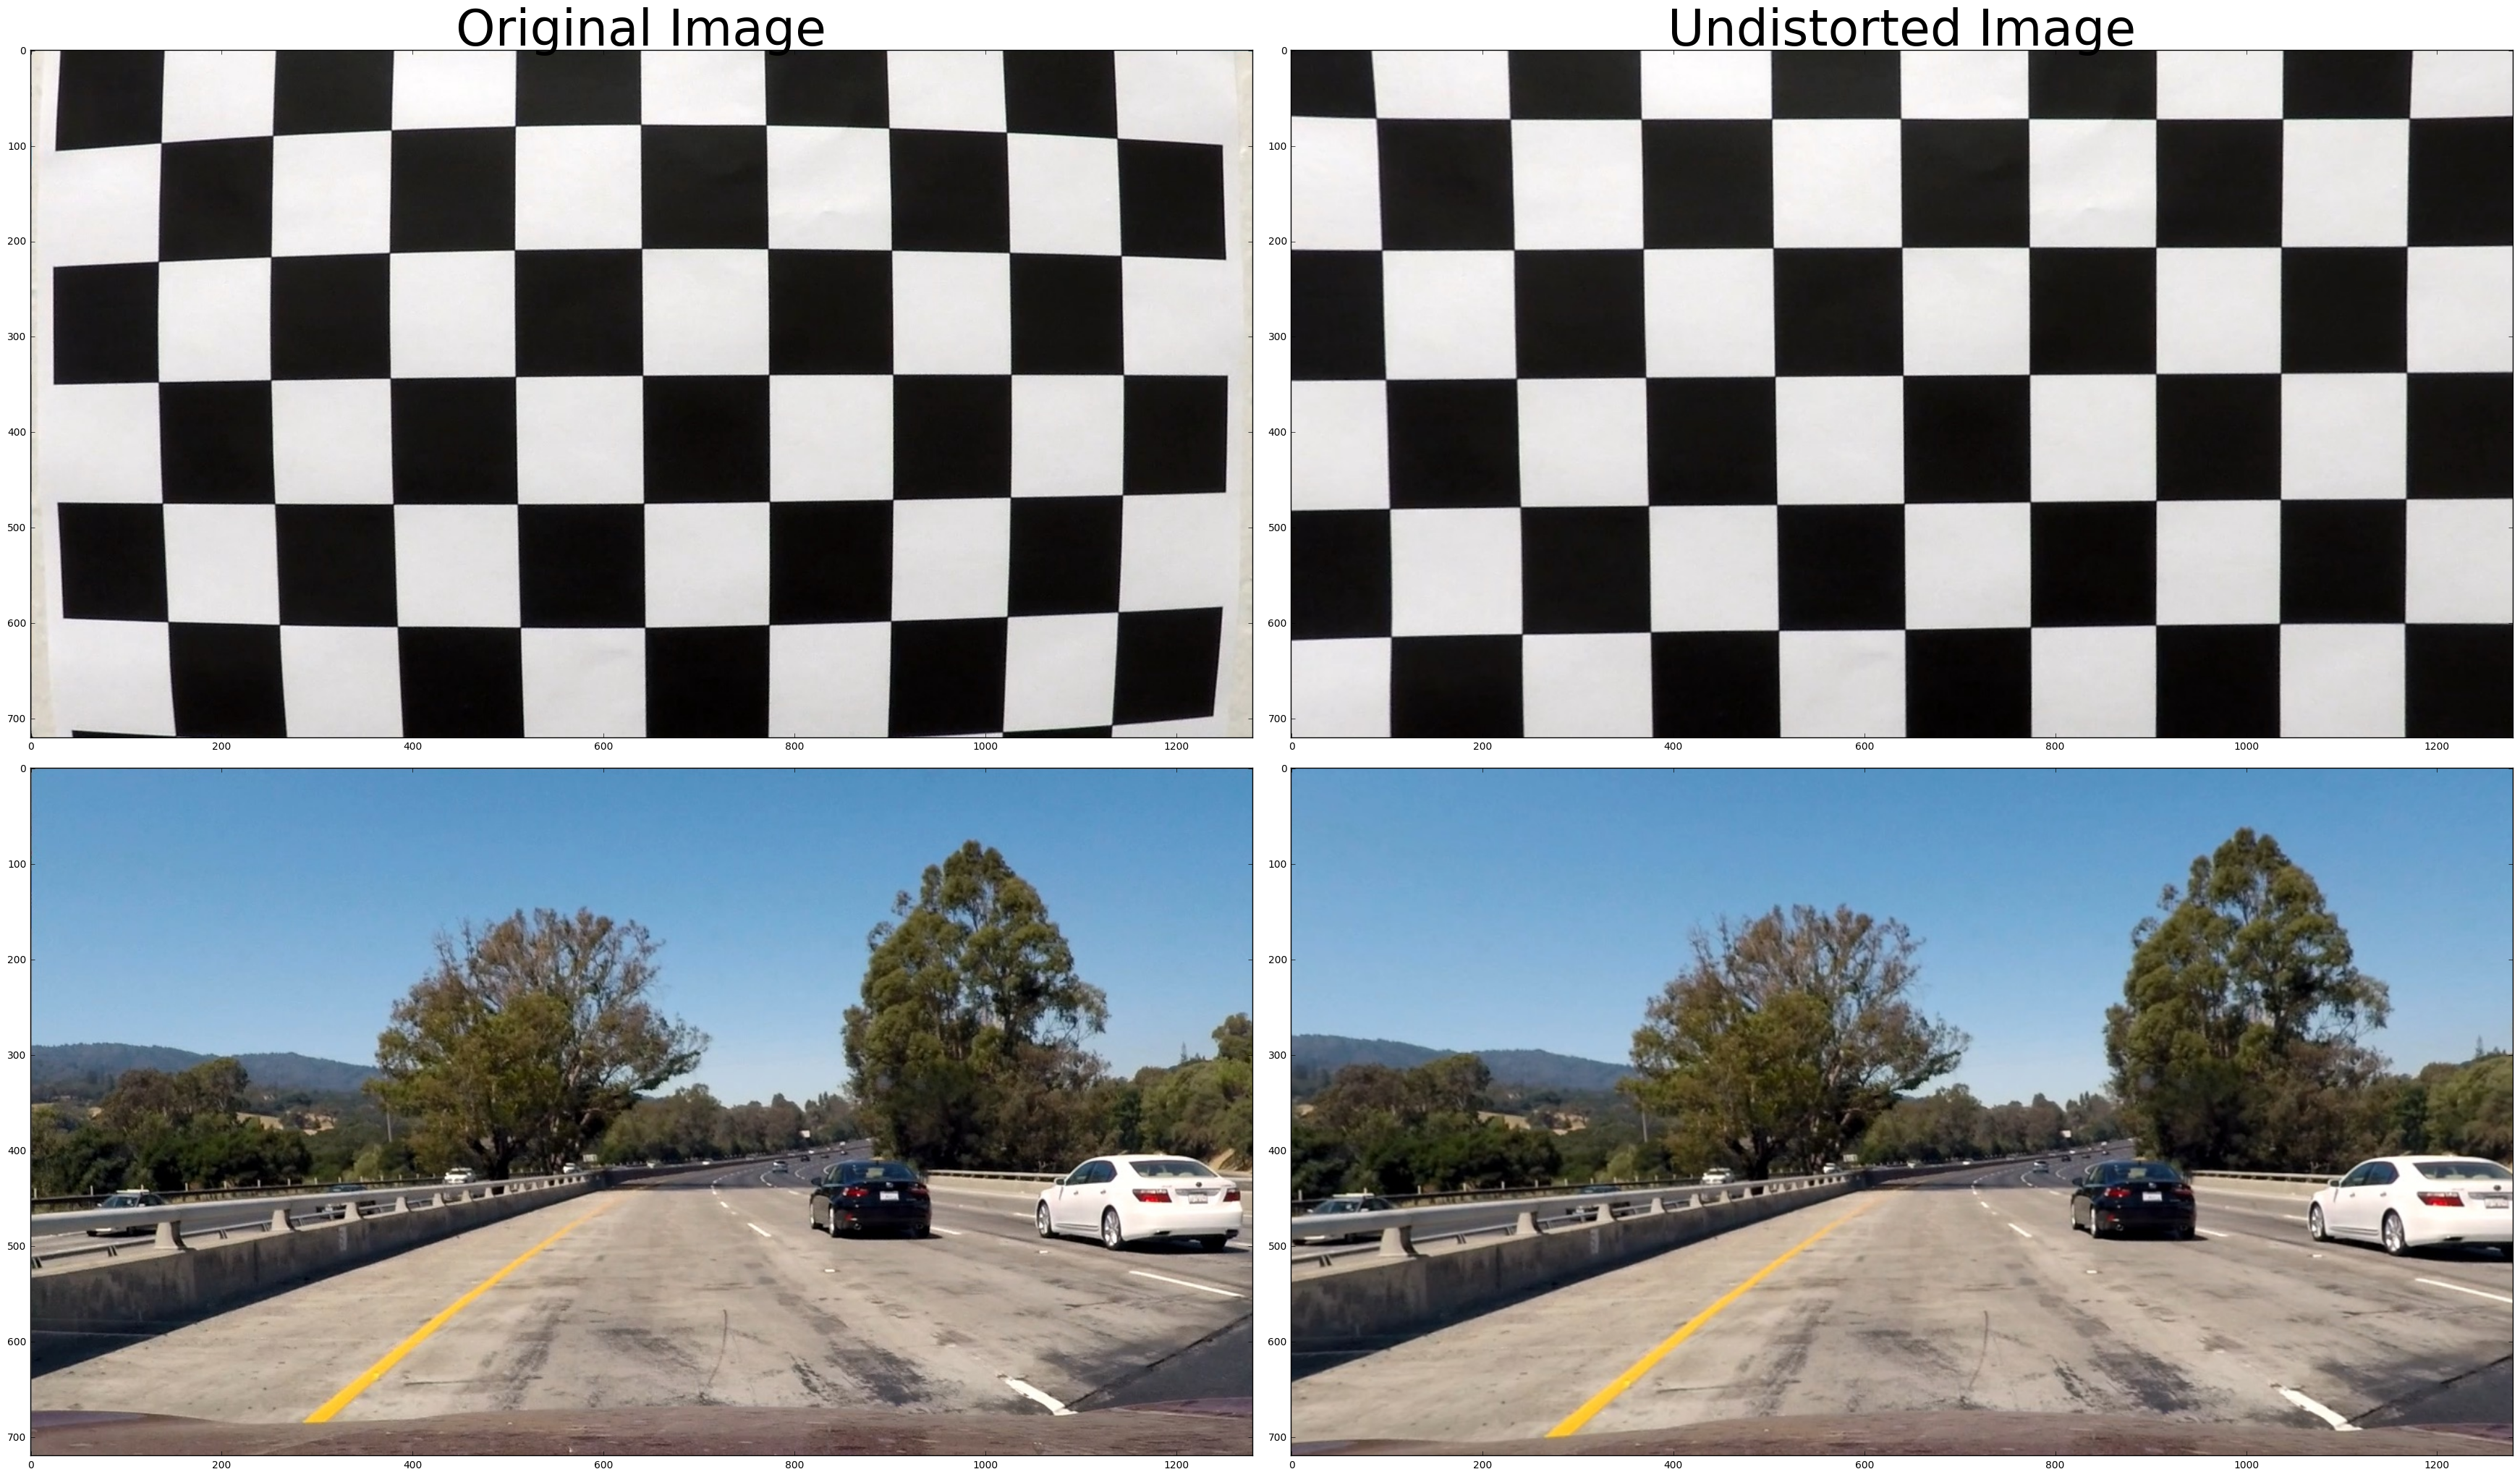

In [3]:
# Show an example here

img1 = mpimg.imread('./camera_cal/calibration1.jpg')
img2 = mpimg.imread('./test_images/test1.jpg')
undist1 = cv2.undistort(img1, mtx, dist)
undist2 = cv2.undistort(img2, mtx, dist)

f, (ax1, ax2) = plt.subplots(2, 2, figsize=(35, 20))
f.tight_layout()
ax1[0].imshow(img1)
ax1[0].set_title('Original Image', fontsize=50)
ax1[1].imshow(undist1)
ax1[1].set_title('Undistorted Image', fontsize=50)
ax2[0].imshow(img2)
ax2[1].imshow(undist2)

## Define some helper functions used in Pipeline

In [4]:
def abs_sobel_threshold(gray, orient='x', sobel_kernel=3, thresh=(0, 255)):
    """calculate gradients horizontally or vertically 
    return a mask fitted in the threshold.
    """
    if orient=='x':
        sobel = np.abs(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    else:
        sobel = np.abs(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    sobel = np.uint(sobel*255/np.max(sobel))
    grad_binary = np.zeros_like(gray)
    grad_binary[(sobel>thresh[0])&(sobel<thresh[1])] = 1
    return grad_binary


def hls_select(img, thresh=(0, 255)):
    """select color area fitted in the threshold in S channel. 
    """
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    S = hls[:,:,2]
    binary_output = np.zeros_like(S)
    binary_output[(S>thresh[0])&(S<=thresh[1])] = 1
    return binary_output


def hsv_select(img, thresh):
    """helper function to select yellow and white areas.
    """
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    white_mask = cv2.inRange(hsv, thresh['lower_white'], thresh['upper_white'])
    yellow_mask = cv2.inRange(hsv, thresh['lower_yellow'], thresh['upper_yellow'])
    hsv_binary = np.zeros_like(img[:,:,0])
    mask = (white_mask | yellow_mask)
    hsv_binary[mask>0] = 1
    return hsv_binary
    

def region_of_interest(img, vertices):
    """Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    mask = np.zeros_like(img)   
    if len(img.shape) > 2:
        channel_count = img.shape[2] 
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_curvature(img, L_line, R_line, cur_thresh=2000):
    """Function to draw curvature and position on the image.
    """
    curvature = min(L_line.radius_of_curvature, R_line.radius_of_curvature)
    if np.abs(curvature) > 2000:
        cv2.putText(img, 'The road is nearly straight.', (100, 100), 0, 1, (255, 255, 0), 2)
        cv2.putText(img, 'The car is %.2fm away from center.'%R_line.line_base_pos, (100, 140), 
                    0, 1, (255, 255, 0), 2)
    elif curvature < 0:
        cv2.putText(img, 'The lane curvature is %.2fm to the left.'%(-curvature), (100, 100), 
                    0, 1, (255, 255, 0), 2)
        cv2.putText(img, 'The car is %.2fm away from center.'%R_line.line_base_pos, (100, 140),  
                    0, 1, (255, 255, 0), 2)
    else:
        cv2.putText(img, 'The lane curvature is %.2fm to the right.'%curvature, (100, 100), 
                    0, 1, (255, 255, 0), 2)
        cv2.putText(img, 'The car is %.2fm away from center.'%R_line.line_base_pos, (100, 140), 
                    0, 1, (255, 255, 0), 2)
    return img
        
        
class Line:
    """The class for updating and keeping track of lane lines.
    """
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False
        self.fail_times = 0
        # x values of the last n fits of the line
        self.recent_xfitted = np.array([])       
        #average x values of the fitted line over the last n iterationsnum_records=3, diff_thresh=[1e-4, 1e-1, 60], max_fail=100
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = np.array([i for i in range(719, -1, -1)])
        
    def find_lane_lines(self, binary_img, centers, shift=100, y_start=160, step=90,
                        num_records=20, diff_thresh=[2e-4, 2e-1, 100], max_fail=40):
        """Calculate current lane line.
        """
        Xs, Ys = [], []
        median = np.median(np.array(centers))
        for i, center in enumerate(centers):
            Y, X = np.where(binary_img[719-(i+1)*step:719-i*step, center-shift:center+shift]==1)
            if not X.any() or not Y.any() :
                continue
            X += center-shift
            Y += 719-(i+1)*step
            Xs.append(X)
            Ys.append(Y)
            
        if len(Xs)==0 and self.best_fit is not None:
            ws = self.best_fit
        elif len(Xs)==0:
            ws = np.array([0., 0., 0.])
        else:
            Xs = np.hstack(Xs)
            Ys = np.hstack(Ys)
            ws = np.polyfit(Ys, Xs, 2)
        
        if self.bestx is None:
            self.best_fit = ws
            self.current_fit = np.array([ws])
            self.allx = (self.best_fit[0]*self.ally**2 + self.best_fit[1]*self.ally \
                         + self.best_fit[2]).astype(np.int32)
            self.bestx = self.allx
            self.recent_xfitted = np.array([self.allx])
            self.calculate_curvature()
            return
        
        self.diffs = np.abs(ws - self.best_fit)
        if self.diffs[0]<diff_thresh[0] and self.diffs[1]<diff_thresh[1] and self.diffs[2]<diff_thresh[2]:
            self.detected = True
            if len(self.recent_xfitted) >= num_records:
                self.recent_xfitted = self.recent_xfitted[1:]
                self.current_fit = self.current_fit[1:]
        
            self.current_fit = np.vstack([self.current_fit, ws])
            self.best_fit = np.mean(self.current_fit, axis=0)
            self.allx = (self.best_fit[0]*self.ally**2 + self.best_fit[1]*self.ally \
                         + self.best_fit[2]).astype(np.int32)
            self.recent_xfitted = np.vstack([self.recent_xfitted, self.allx])
            self.bestx = np.mean(self.recent_xfitted, axis=0)
            self.calculate_curvature()
            self.fail_times = 0
        elif self.best_fit[0] == 0. and self.best_fit[1] == 0. and self.best_fit[2] == 0.:
            self.best_fit = ws 
            self.current_fit = np.array([ws])
            self.allx = (self.best_fit[0]*self.ally**2 + self.best_fit[1]*self.ally \
                         + self.best_fit[2]).astype(np.int32)
            self.bestx = self.allx
            self.recent_xfitted = np.array([self.allx])
            self.calculate_curvature()
        else:
            self.detected = False
            self.fail_times += 1
            if self.fail_times > max_fail:
                self.fail_times = 0
                self.best_fit = ws  
                self.current_fit = np.array([ws])
                self.allx = (self.best_fit[0]*self.ally**2 + self.best_fit[1]*self.ally \
                             + self.best_fit[2]).astype(np.int32)
                self.bestx = self.allx
                self.recent_xfitted = np.array([self.allx])
                self.calculate_curvature()
        
    def calculate_curvature(self, ym_per_pix=30./720, xm_per_pix=3.7/700):
        """Calculate lane curvature and car position from the lane center.
        """
        X = self.allx * xm_per_pix
        Y = self.ally * ym_per_pix
        W = np.polyfit(Y, X, 2)
        y = np.max(Y)
        cur = ((1 + (2*W[0]*y + W[1])**2)**1.5)/2/W[0]
        self.radius_of_curvature = cur
        if X[0] > 650*xm_per_pix:
            self.line_base_pos = 950*xm_per_pix - X[0]

In [5]:
class Config:
    """class for storing parameters that would be tuned frequently.
    """
    # thresholds for color selection
    hls_thresh = (100, 255)
    hsv_thresh = {'lower_white': np.array([0, 0, 200]), 
                  'upper_white': np.array([100, 100, 255]), 
                  'lower_yellow': np.array([20, 80, 170]), 
                  'upper_yellow': np.array([120, 200, 255])
                 }
    # horizontal gradient thresholds
    sobel_x_thresh = (50, 100)
    # region of interests
    vertices = np.int32([[(203, 720), (585, 460), (730, 460), (1160, 720)]]) 
    # source points and destination points for transforming
    src = np.float32([(183, 720), (565, 460), (730, 460), (1160, 720)])
    dst = np.float32([(320, 720), (320,   0), (960,   0), ( 960, 720)])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    hist_start = 450
    hist_step = 25
    L_shift = 50
    L_num_records = 40
    L_diff_thresh = [2e-4, 2e-1, 150]
    L_max_fail = 40
    R_shift = 50
    R_num_records = 40
    R_diff_thresh = [2e-4, 2e-1, 150]
    R_max_fail = 40 

## Setup the processing Pipeline

In [6]:
def processing_image(img, L_line, R_line, mtx, dist, cfg):
    """image processing function for vedios.
    
    args:
        img, RGB image,
        L_line, left lane line, instance of Line class
        R_line, right lane line, instance of line class
        mtx, camera matrix,
        dist, distortion coefficients,
        cfg, pipeline paramters, instance of Config class.
    return:
        result, processed image.
    """
    # to make sure the image shape is 1280*720 
    if img.shape[:-1] != [1280, 720]:
        img = cv2.resize(img, (1280, 720))
    # undistort the image.
    undist = cv2.undistort(img, mtx, dist)
    # apply color selection to the image
    hls_binary = hls_select(undist, cfg.hls_thresh)
    hsv_binary = hsv_select(undist, cfg.hsv_thresh)
    # apply gradient selection to the image
    gray = cv2.cvtColor(undist, cv2.COLOR_RGB2GRAY)
    dx = abs_sobel_threshold(gray, 'x', 3, cfg.sobel_x_thresh)
    # combine them together
    binary = np.zeros_like(gray)
    binary[(dx==1)|(hsv_binary==1)|(hls_binary==1)] = 1
    binary = region_of_interest(binary, cfg.vertices)
    # transform perspective
    warped = cv2.warpPerspective(binary, cfg.M, (1280, 720), flags=cv2.INTER_LINEAR)
    # find centers for each step and use these centers to find lane lines
    L_centers = []
    R_centers = []
    for i in range(cfg.hist_start//cfg.hist_step):
        hist = np.sum(warped[719-(i+1)*cfg.hist_step:719-i*cfg.hist_step, :], axis=0)
        L_center = np.argmax(hist[:440])
        R_center = np.argmax(hist[840:]) + 840
        L_centers.append(L_center)
        R_centers.append(R_center)
    
    L_line.find_lane_lines(warped, L_centers, shift=cfg.L_shift, step=cfg.hist_step, 
                           num_records=cfg.L_num_records, diff_thresh=cfg.L_diff_thresh, 
                           max_fail=cfg.L_max_fail)
    R_line.find_lane_lines(warped, R_centers, shift=cfg.R_shift, step=cfg.hist_step, 
                           num_records=cfg.R_num_records, diff_thresh=cfg.R_diff_thresh, 
                           max_fail=cfg.R_max_fail)
    # plot the area between the detected two lines
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    pts_left = np.array([np.transpose(np.vstack([L_line.allx, L_line.ally]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([R_line.allx, R_line.ally])))])
    pts = np.hstack((pts_left, pts_right))
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))
    # transform back
    newwarp = cv2.warpPerspective(color_warp, cfg.Minv, (1280, 720))
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    # display curvature and position on the image
    result = draw_curvature(result, L_line, R_line)
    return result

## Processing single images

In [7]:
def single_image_processing(img, L_line, R_line, mtx, dist, cfg):
    
    if img.shape[:-1] != [1280, 720]:
        img = cv2.resize(img, (1280, 720))
    undist = cv2.undistort(img, mtx, dist)
    hls_binary = hls_select(undist, cfg.hls_thresh)
    hsv_binary = hsv_select(undist, cfg.hsv_thresh)
    gray = cv2.cvtColor(undist, cv2.COLOR_RGB2GRAY)
    dx = abs_sobel_threshold(gray, 'x', 3, cfg.sobel_x_thresh)
    binary = np.zeros_like(gray)
    binary[(dx==1)|(hsv_binary==1)|(hls_binary==1)] = 1
    binary = region_of_interest(binary, cfg.vertices)
    warped = cv2.warpPerspective(binary, cfg.M, (1280, 720), flags=cv2.INTER_LINEAR)
    undist_warped = cv2.warpPerspective(undist, cfg.M, (1280, 720), flags=cv2.INTER_LINEAR)
    L_centers = []
    R_centers = []
    for i in range(cfg.hist_start//cfg.hist_step):
        hist = np.sum(warped[719-(i+1)*cfg.hist_step:719-i*cfg.hist_step, :], axis=0)
        L_center = np.argmax(hist[:440])
        R_center = np.argmax(hist[840:]) + 840
        L_centers.append(L_center)
        R_centers.append(R_center)
        
    L_line.find_lane_lines(warped, L_centers, shift=cfg.L_shift, step=cfg.hist_step, 
                           num_records=cfg.L_num_records, diff_thresh=cfg.L_diff_thresh, 
                           max_fail=cfg.L_max_fail)
    R_line.find_lane_lines(warped, R_centers, shift=cfg.R_shift, step=cfg.hist_step, 
                           num_records=cfg.R_num_records, diff_thresh=cfg.R_diff_thresh, 
                           max_fail=cfg.R_max_fail)
    for (x, y) in zip(L_line.allx, L_line.ally):
        for i in range(7):
            undist_warped[y, x+i, 0] = 255
            undist_warped[y, x-i, 0] = 255
            undist_warped[y, x+i, 1] = 0
            undist_warped[y, x-i, 1] = 0
            undist_warped[y, x+i, 2] = 0
            undist_warped[y, x-i, 2] = 0
    for (x, y) in zip(R_line.allx, R_line.ally):
        for i in range(7):
            undist_warped[y, x+i, 0] = 0
            undist_warped[y, x-i, 0] = 0
            undist_warped[y, x+i, 1] = 255
            undist_warped[y, x-i, 1] = 255
            undist_warped[y, x+i, 2] = 0
            undist_warped[y, x-i, 2] = 0
            
    unwarped = cv2.warpPerspective(warped, cfg.Minv, (1280, 720))
    undist_unwarped = cv2.warpPerspective(undist_warped, cfg.Minv, (1280, 720))
    undist_unwarped = cv2.addWeighted(undist, 1, undist_unwarped, 0.7, 0)
    return undist, binary, warped, undist_warped, undist_unwarped

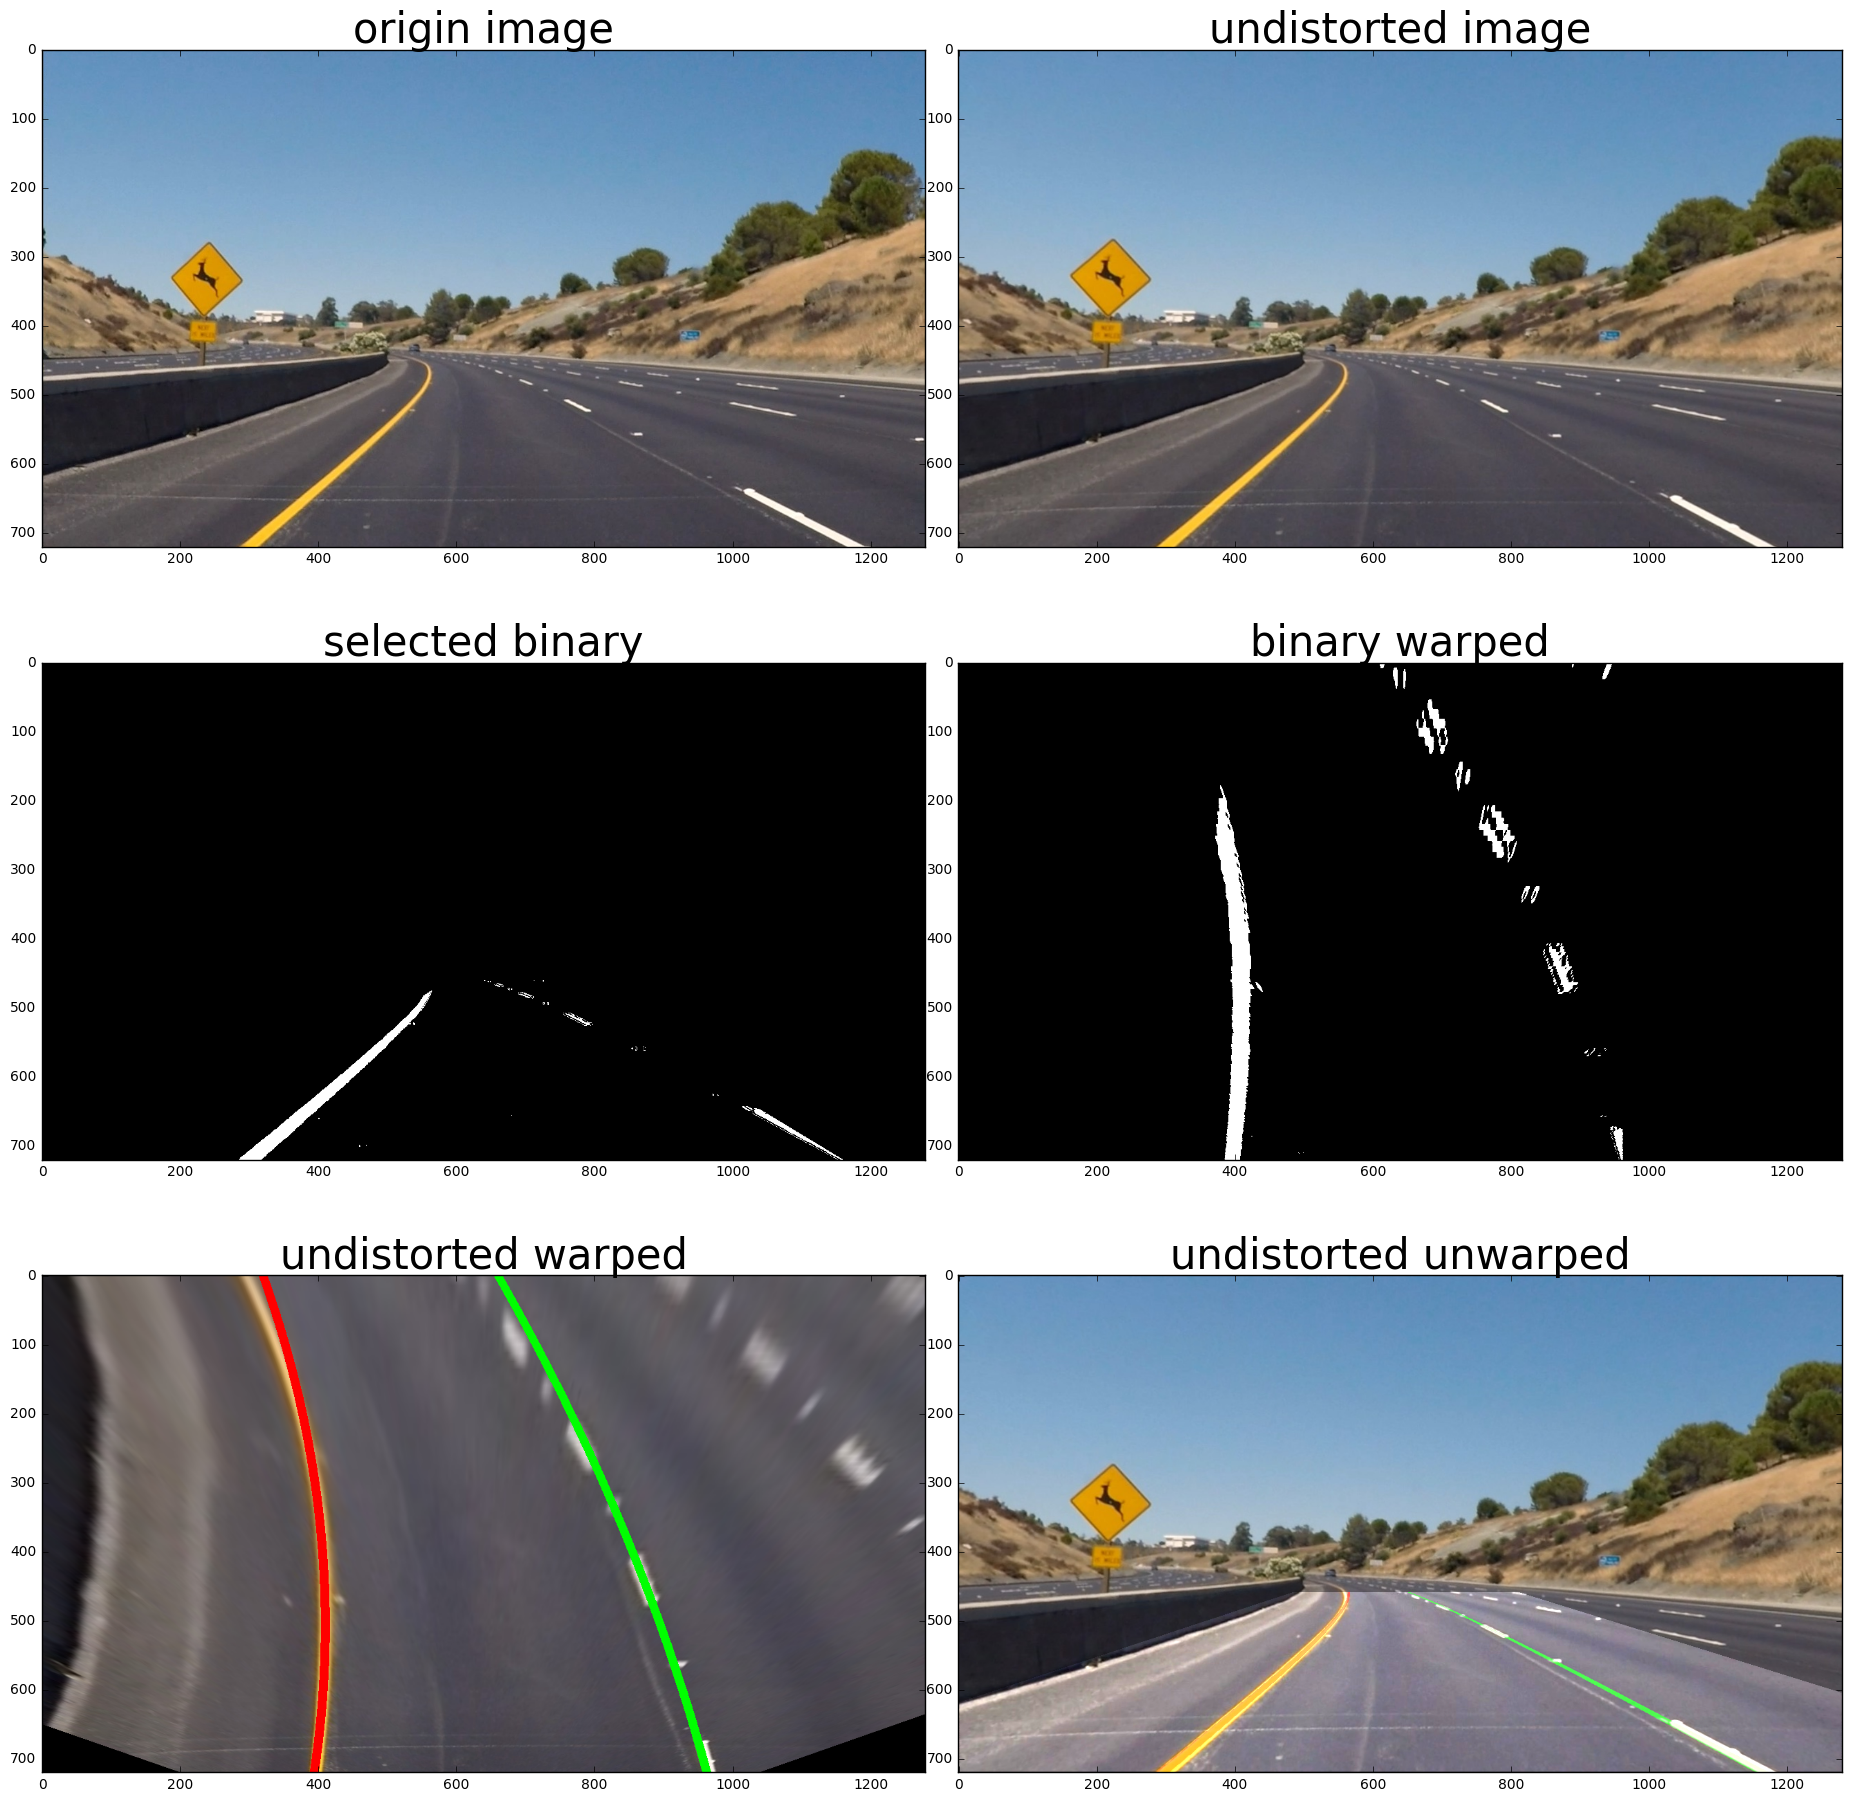

In [8]:
example = './test_images/test2.jpg'
img = mpimg.imread(example)
L_line = Line()
R_line = Line()
cfg = Config()
result = single_image_processing(img, L_line, R_line, mtx, dist, cfg)

f, (ax1, ax2, ax3) = plt.subplots(3, 2, figsize=(30, 20))
f.tight_layout()
ax1[0].imshow(img)
ax1[0].set_title('origin image', fontsize=30)
ax1[1].imshow(result[0], cmap='gray')
ax1[1].set_title('undistorted image', fontsize=30)
ax2[0].imshow(result[1], 'gray')
ax2[0].set_title('selected binary', fontsize=30)
ax2[1].imshow(result[2], 'gray')
ax2[1].set_title('binary warped', fontsize=30)
ax3[0].imshow(result[3], 'gray')
ax3[0].set_title('undistorted warped', fontsize=30)
ax3[1].imshow(result[4], 'gray')
ax3[1].set_title('undistorted unwarped', fontsize=30)
plt.subplots_adjust(left=0.2, right=0.8, top=0.9, bottom=0.)

## Processing videos here

In [9]:
output = 'project_video_ans3.mp4'
clip1 = VideoFileClip("project_video.mp4")
L_line = Line()
R_line = Line()
cfg = Config()
process_images = lambda img: processing_image(img, L_line, R_line, mtx, dist, cfg)
res_clip = clip1.fl_image(process_images) 
%time res_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video project_video_ans3.mp4
[MoviePy] Writing video project_video_ans3.mp4


100%|█████████▉| 1260/1261 [01:14<00:00, 17.55it/s]    | 2/1261 [00:00<01:49, 11.54it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_ans3.mp4 

CPU times: user 2min, sys: 2.44 s, total: 2min 2s
Wall time: 1min 15s


In [10]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

In [11]:
challenge_output = 'challenge_video_ans.mp4'
clip1 = VideoFileClip("challenge_video.mp4")
L_line = Line()
R_line = Line()
cfg = Config()
process_images = lambda img: processing_image(img, L_line, R_line, mtx, dist, cfg)
challenge_clip = clip1.fl_image(process_images)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video challenge_video_ans.mp4
[MoviePy] Writing video challenge_video_ans.mp4


100%|██████████| 485/485 [00:28<00:00, 16.97it/s]     | 2/485 [00:00<00:29, 16.18it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_ans.mp4 

CPU times: user 45.8 s, sys: 808 ms, total: 46.6 s
Wall time: 29.1 s


In [12]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))